## Compare receiver function deconvolution methods

This notebook uses the [rf](https://github.com/trichter/rf) package to compare the results of different deconvolution methods.

If you want to run this notebook locally, check the repository [readme](https://github.com/hfmark/notebooks) for some instructions on installing dependencies. For this notebook you will need to have obspy and rf installed.

To start, we load example data into an RFStream instance by calling `read_rf()`. Calling this function without other arguments loads the sample dataset provided with the rf package. The stream consists of 3-component data from 3 earthquakes, 9 traces in total.

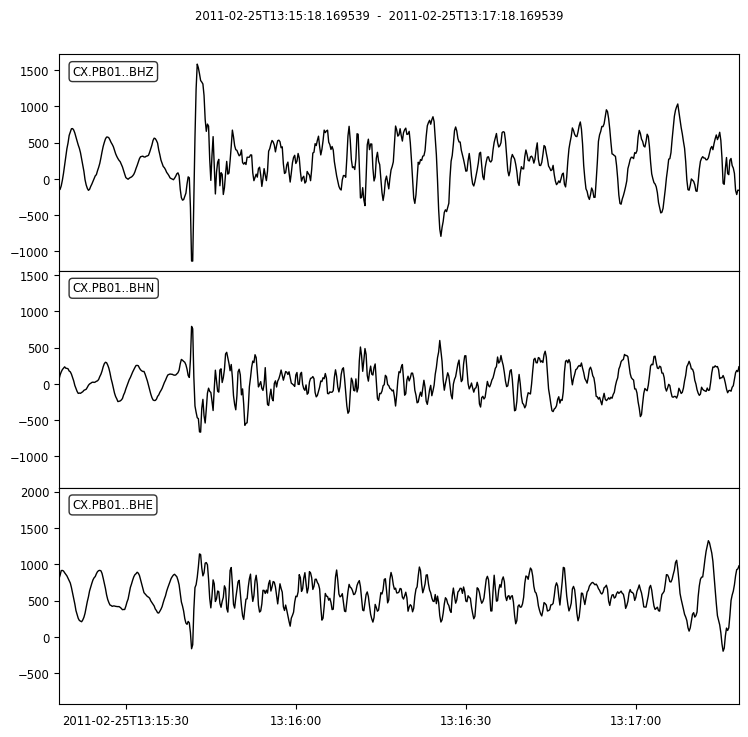

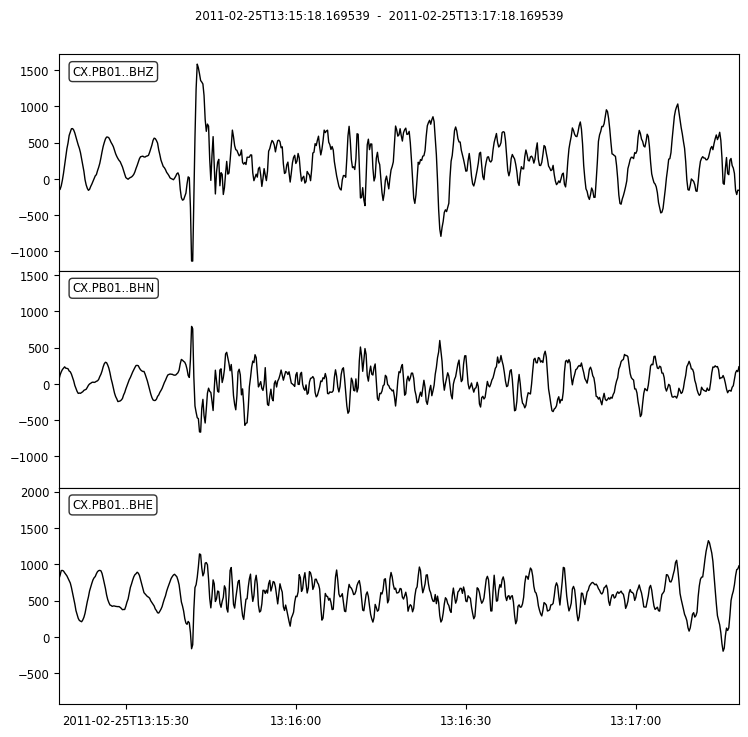

In [11]:
import matplotlib.pyplot as plt
from rf import read_rf, rfstats

stream = read_rf()
# plot the first 3 traces/data from the first event
stream[:3].plot()

Next, the rfstats function helps us fill in header info for the receiver function calculation, including onset time.

In [12]:
rfstats(stream)

9 Trace(s) in Stream:
CX.PB01..BHE | -20.0s - 100.0s onset:2011-02-25T13:15:38.137852Z | 5.0 Hz, 601 samples | mag:6.0 dist:46.1 baz:325.0 slow:7.83
CX.PB01..BHN | -20.0s - 100.0s onset:2011-02-25T13:15:38.137852Z | 5.0 Hz, 601 samples | mag:6.0 dist:46.1 baz:325.0 slow:7.83
CX.PB01..BHZ | -20.0s - 100.0s onset:2011-02-25T13:15:38.137852Z | 5.0 Hz, 601 samples | mag:6.0 dist:46.1 baz:325.0 slow:7.83
CX.PB01..BHE | -20.1s - 99.9s onset:2011-03-06T14:40:59.799529Z | 5.0 Hz, 601 samples | mag:6.5 dist:47.1 baz:149.2 slow:7.77
CX.PB01..BHN | -20.1s - 99.9s onset:2011-03-06T14:40:59.799529Z | 5.0 Hz, 601 samples | mag:6.5 dist:47.1 baz:149.2 slow:7.77
CX.PB01..BHZ | -20.1s - 99.9s onset:2011-03-06T14:40:59.799529Z | 5.0 Hz, 601 samples | mag:6.5 dist:47.1 baz:149.2 slow:7.77
CX.PB01..BHE | -20.0s - 100.0s onset:2011-05-13T22:54:33.294357Z | 5.0 Hz, 601 samples | mag:6.0 dist:34.2 baz:333.6 slow:8.63
CX.PB01..BHN | -20.0s - 100.0s onset:2011-05-13T22:54:33.294357Z | 5.0 Hz, 601 samples | mag

The data need a little preprocessing:

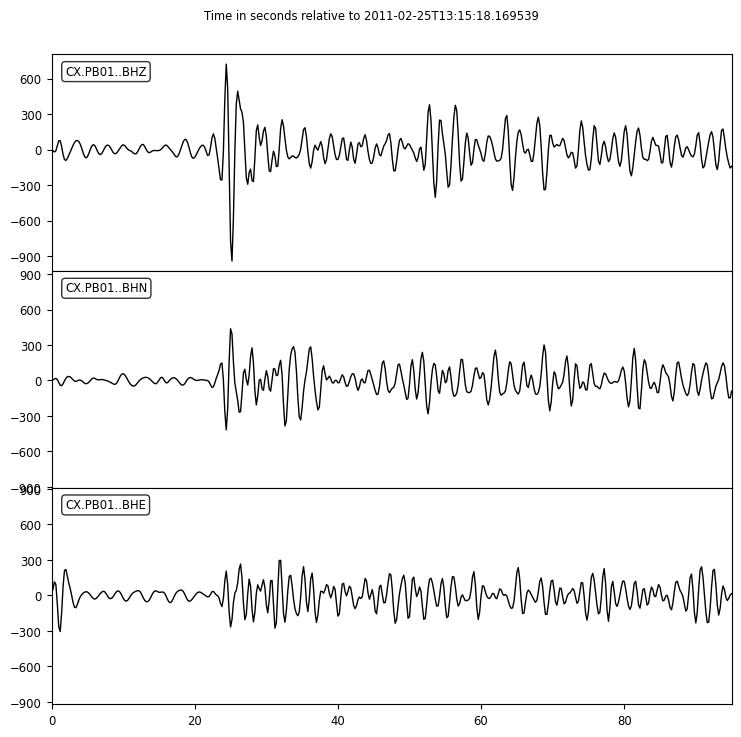

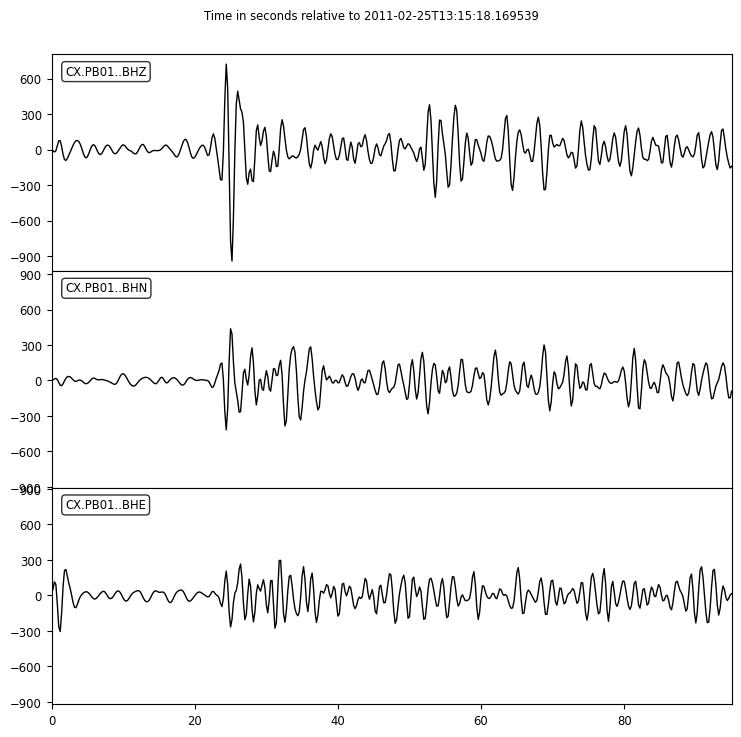

In [13]:
stream.filter('bandpass', freqmin=0.33, freqmax=1)
stream.trim2(-25,75,'onset')
stream[:3].plot(type='relative')

Next, we make copies of the stream and do the receiver function calculation (rotation, deconvolution, moveout correction) using different deconvolution methods: time- and frequency-domain water level, and time-domain iterative.

In [30]:
rf_time = stream.copy().rf(deconvolve='time',rotate='NE->RT',solve_toeplitz='scipy').moveout()
rf_freq = stream.copy().rf(deconvolve='freq',rotate='NE->RT').moveout()
rf_iter = stream.copy().rf(deconvolve='iter',rotate='NE->RT').moveout()

rf_time.trim2(-5,20,'onset')
rf_freq.trim2(-5,20,'onset')
rf_iter.trim2(-5,20,'onset')

9 Trace(s) in Stream:
Prf CX.PB01..BHT | -5.0s - 20.0s onset:2011-02-25T13:15:38.169539Z | 5.0 Hz, 126 samples | mag:6.0 dist:46.1 baz:325.0 slow:6.40 (Ps moveout)
Prf CX.PB01..BHR | -5.0s - 20.0s onset:2011-02-25T13:15:38.169539Z | 5.0 Hz, 126 samples | mag:6.0 dist:46.1 baz:325.0 slow:6.40 (Ps moveout)
Prf CX.PB01..BHZ | -5.0s - 20.0s onset:2011-02-25T13:15:38.169539Z | 5.0 Hz, 126 samples | mag:6.0 dist:46.1 baz:325.0 slow:6.40 (Ps moveout)
Prf CX.PB01..BHT | -5.0s - 20.0s onset:2011-03-06T14:40:59.719539Z | 5.0 Hz, 126 samples | mag:6.5 dist:47.1 baz:149.2 slow:6.40 (Ps moveout)
Prf CX.PB01..BHR | -5.0s - 20.0s onset:2011-03-06T14:40:59.719539Z | 5.0 Hz, 126 samples | mag:6.5 dist:47.1 baz:149.2 slow:6.40 (Ps moveout)
Prf CX.PB01..BHZ | -5.0s - 20.0s onset:2011-03-06T14:40:59.719539Z | 5.0 Hz, 126 samples | mag:6.5 dist:47.1 baz:149.2 slow:6.40 (Ps moveout)
Prf CX.PB01..BHT | -5.0s - 20.0s onset:2011-05-13T22:54:33.319538Z | 5.0 Hz, 126 samples | mag:6.0 dist:34.2 baz:333.6 slow:6.

We can plot and examine the radial components (since these are PRFs) for each method

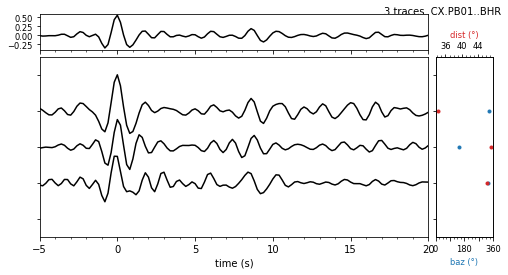

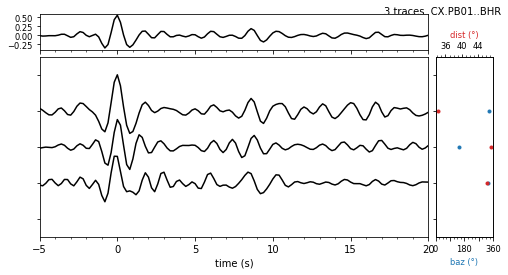

In [31]:
rf_time.select(component='R').plot_rf()

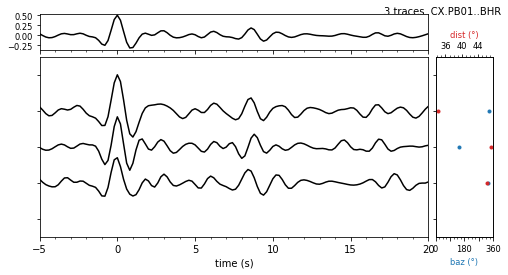

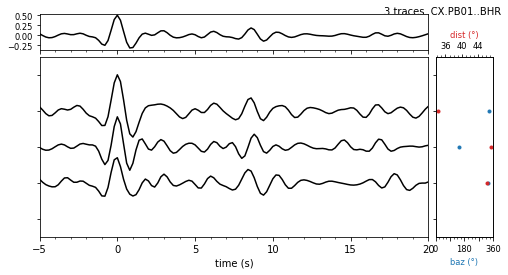

In [32]:
rf_freq.select(component='R').plot_rf()

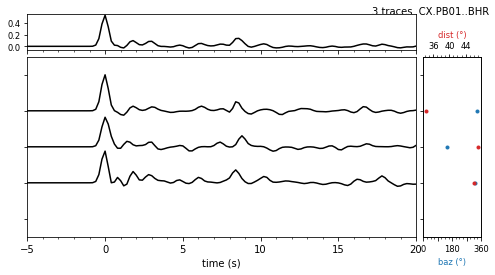

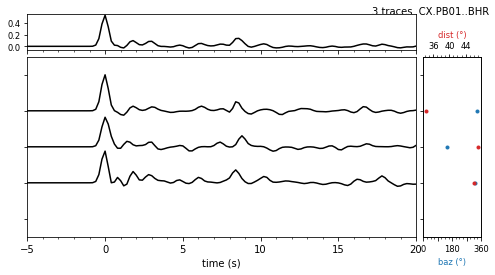

In [33]:
rf_iter.select(component='R').plot_rf()

We can also make a comparison plot overlaying the RFs for one event from each deconvolution method

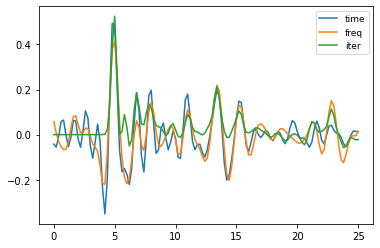

In [41]:
evt = 0  # choose 0, 1, or 2
rflist = [rf_time,rf_freq,rf_iter]; labels = ['time','freq','iter']
plt.figure()
for i,st in enumerate(rflist):
    sel = st[int(3*evt):int(3*(evt+1))]
    sel = sel.select(component='R')
    plt.plot(sel[0].times(),sel[0].data,label=labels[i])
plt.legend(fontsize=9)

A similar plot can be made with the stacked RFs for each deconvolution method

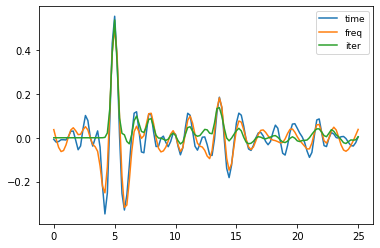

In [44]:
rflist = [rf_time,rf_freq,rf_iter]; labels = ['time','freq','iter']
plt.figure()
for i,st in enumerate(rflist):
    sel = st.copy().select(component='R').stack()
    plt.plot(sel[0].times(),sel[0].data,label=labels[i])
plt.legend(fontsize=9)